In [1]:
# import importlib
# importlib.reload(config)
# import utils.config as config

In [2]:
import pandas as pd
import utils.config as config
import numpy as np
import utils.util as util
# pd.set_option('display.max_colwidth', None)

## Analysis - dataset licenses

with manually checked dataset licenses

In [2]:
df_bm_labels_all_merged = pd.read_excel(config.path_kaggle_benchmark_sheet_all_data_license_complete_processed, keep_default_na=False)

In [3]:
assert(df_bm_labels_all_merged[(df_bm_labels_all_merged["DatasetLicenseName_1"].isna() | 
                                (df_bm_labels_all_merged["DatasetLicenseName_1"] == "NaN"))].shape[0]==0)

In [4]:
from collections import Counter

# Combine value_counts for multiple columns
columns = ["DatasetLicenseName_1", "DatasetLicenseName_2"]

combined_counter = Counter()
for col in columns:
    values = df_bm_labels_all_merged[col]
    cleaned_values = values[values.notna() & (values != "")]
    combined_counter += Counter(cleaned_values)

# Convert back to a Series if you want the Pandas style
license_count = pd.Series(combined_counter).sort_values(ascending=False)

In [5]:
pd.DataFrame(license_count)

,0
Unknown,40
CC0: Public Domain,19
MIT,10
"Database: Open Database, Contents: Database Contents (DbCL)",9
Allow academic research,7
Attribution 4.0 International (CC BY 4.0),7
No private sharing outside teams,3
GPL 2,3
Apache 2.0,3
"Competition Use and Academic, Non-Commercial Use Only",3


In [6]:
len(license_count)

20

In [7]:
license_private = ['No private sharing outside teams', 'Data files © Original Authors']

In [9]:
def check_license_public(row):
    is_public = True
    for i in range(1,3,1):
        col_name = "DatasetLicenseName_"+str(i)
        if row[col_name] and (row[col_name] in license_private):
            is_public = False
            break
    return is_public

df_bm_labels_all_merged_privatedata = df_bm_labels_all_merged[~df_bm_labels_all_merged.apply(check_license_public, axis=1)]

In [11]:
df_bm_labels_all_merged_privatedata.Dataset_note

36     synthetic
62     synthetic
98     synthetic
100    synthetic
Name: Dataset_note, dtype: object

## Analysis - benchmark statistics

In [9]:
# import utils.data_labeled_process as data_labeled_process

# df_bm_labels_all_merged = pd.read_excel(config.path_kaggle_benchmark_sheet_all_data_license_complete, keep_default_na=False)
# df_bm_labels_config = pd.read_excel(config.path_kaggle_benchmark_sheet, sheet_name = "Config", keep_default_na=False)
# config_exclude = ['label_if_runinfo_help', 'label_if_code_error_align', 'other', 'Libs_cause', 'Reproduce']
# df_bm_labels_config.drop(config_exclude, axis=1, inplace=True)
# # df_bm_labels['other'].replace([0], "", inplace=True)

# data_labeled_process.labeled_data_config_clean(df_bm_labels_all_merged, 
#                                                df_bm_labels_config)
# # Map the summarized config to config and the data
# data_labeled_process.labeled_data_config_sum(df_bm_labels_all_merged, 
#                                              df_bm_labels_config,
#                                              save_config_path = config.path_kaggle_benchmark_sheet_all_data_license_complete_processed)

### Library distribution

In [3]:
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
from matplotlib.ticker import MaxNLocator

df_bm_labels_all_merged = pd.read_excel(config.path_kaggle_benchmark_sheet_all_data_license_complete_processed, keep_default_na=False)
df_bm_labels_all_merged.loc[df_bm_labels_all_merged["Libs-cause"]=="None","Libs-cause"] = "NB-specific"
df_bm_labels_all_merged.loc[df_bm_labels_all_merged["Libs-cause"]=="tensorflow/keras","Libs-cause"] = "TF/K"
dict_lib = df_bm_labels_all_merged["Libs-cause"].value_counts()

reordered_libs = ['NB-specific', 
                  'TF/K', 'torch', 'sklearn', 'numpy', 'pandas', 
                  'seaborn', 'matplotlib', 'statsmodels', 'torchvision', 'lightgbm']

dict_lib = {k: dict_lib[k] for k in reordered_libs}

df_lib = pd.DataFrame.from_dict(dict_lib, orient='index', columns = ["count"])
df_lib.loc["total"] = df_lib.sum()
df_lib

,count
NB-specific,20
TF/K,15
torch,15
sklearn,15
numpy,15
pandas,15
seaborn,6
matplotlib,6
statsmodels,2
torchvision,1


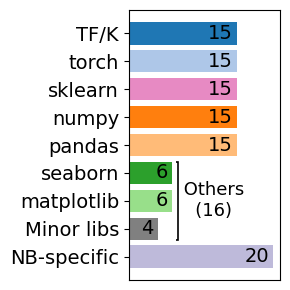

In [9]:
import matplotlib.patches as patches
import utils.util_plot as utilplot

# Major crash causes
main_causes = {k: v for k, v in dict_lib.items() if v >= 5}

# Other libraries
main_causes['Minor libs'] = sum(v for k, v in dict_lib.items() if v < 5)

reordered_libs = ['TF/K', 'torch', 'sklearn', 'numpy', 'pandas', 
                  'seaborn', 'matplotlib', 'Minor libs', 'NB-specific']

main_causes = {k: main_causes[k] for k in reordered_libs}

# Prepare data: main libs + minor libs + nb specific
labels = list(main_causes.keys())
positions = list(range(len(labels)))
bar_widths = list(main_causes.values())

# Colors
notebook_color = cm['Set3'].colors[2:3]
main_lib_colors = cm['tab20'].colors[:2] + cm['Set2'].colors[3:4] + cm['tab20'].colors[2:6] + tuple(['gray'])

# Plot
fig, ax = plt.subplots(figsize=(3, 3))

# Plot notebook-specific in distinct color
ax.barh(positions[-1], bar_widths[-1], color=notebook_color)

# Plot major libraries in consistent color family
for i, (label, width) in enumerate(list(main_causes.items())[:-1]):
    ax.barh(positions[i], width, color=main_lib_colors[i], label=label)

# Axes and styling
ax.set_yticks(positions)
ax.set_yticklabels(labels, fontsize=14)
ax.invert_yaxis()

ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Add numbers at end of bars
for i in range(len(bar_widths)):
        ax.text(
            bar_widths[i] - 0.5,
            positions[i],
            str(bar_widths[i]),
            va='center',
            ha='right',
            fontsize=14
        )

# === Add bracket for Others (matplotlib, seaborn, Minor libs) ===
# These are the 6th, 7th, and 8th items (0-indexed)
start_idx = labels.index('seaborn')
end_idx = labels.index('Minor libs')

y_top = positions[start_idx] - 0.4
y_bottom = positions[end_idx] + 0.4
x = bar_widths[5] + 0.5  # Place bracket slightly to the right of longest bar

# Draw bracket
others_sum = sum([main_causes['seaborn'], main_causes['matplotlib'], main_causes['Minor libs']])
utilplot.draw_bracket(
    ax=ax,
    x=bar_widths[6] + 0.5,
    y_top=positions[labels.index('seaborn')] - 0.4,
    y_bottom=positions[labels.index('Minor libs')] + 0.4,
    label=f" Others\n   ({others_sum})",
    fontsize=13
)

plt.tight_layout()
# plt.savefig(config.path_plot_default.joinpath("library_dist_horizontal.pdf"), bbox_inches='tight')
plt.show()

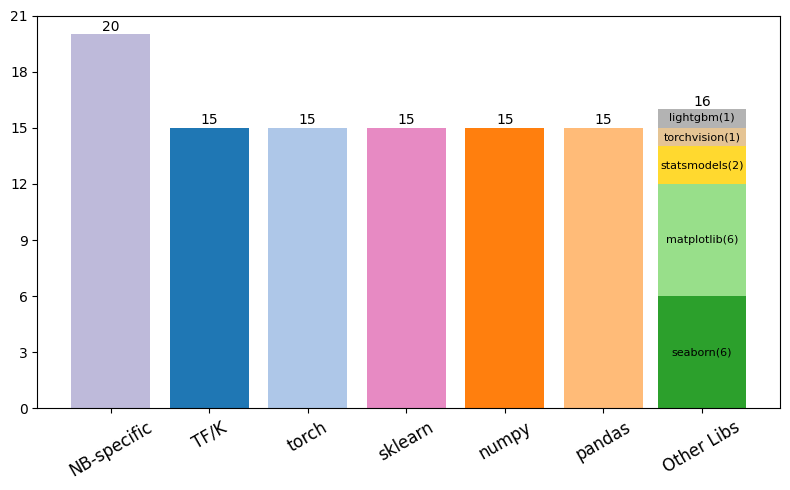

In [10]:
# Major crash causes
main_causes = {k: v for k, v in dict_lib.items() if v>=10}

# Other libraries breakdown
other_libs = {k: v for k, v in dict_lib.items() if v<10}

# Prepare data
labels = list(main_causes.keys()) + ['Other Libs']
positions = list(range(len(labels)))
bar_heights = list(main_causes.values()) + [0]  # placeholder for stacked bar

# Colors
notebook_color = cm['Set3'].colors[2:3]
main_lib_colors = cm['tab20'].colors[:2] + cm['Set2'].colors[3:4] + cm['tab20'].colors[2:4]
other_lib_colors = cm['tab20'].colors[4:6] + cm['Set2'].colors[5:]

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

# Plot notebook-specific in distinct color
ax.bar(positions[0], bar_heights[0], color=notebook_color)

# Plot major libraries in consistent color family
for i, (label, height) in enumerate(list(main_causes.items())[1:]):
    ax.bar(positions[i+1], height, color=main_lib_colors[i], label=label)

# Plot stacked bar for other libraries
bottom = 0
for i, (lib, count) in enumerate(other_libs.items()):
    ax.bar(positions[-1], count, width=0.9, bottom=bottom, color=other_lib_colors[i], label=lib)
    ax.text(positions[-1], bottom + count / 2, f"{lib}({count})", ha='center', va='center', fontsize=8)
    bottom += count

# Axes and styling
ax.set_xticks(positions)
ax.set_xticklabels(labels, rotation=30, fontsize=12)
# ax.set_ylabel('Number of Crashes')
# ax.set_title('Crash Causes in ML Notebooks')

# # legends
# handles, labels = ax.get_legend_handles_labels()
# seen = set()
# unique_handles_labels = [(h, l) for h, l in zip(handles, labels) if not (l in seen or seen.add(l))]
# ax.legend(*zip(*unique_handles_labels), title='Crash Source', bbox_to_anchor=(1.05, 1), loc='upper left')

ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Add numbers on top of non-stacked bars
for i in range(len(bar_heights)):
    if labels[i] == 'Other Libs':
        total = sum(other_libs.values())
        ax.text(
            positions[i],
            total + 0.02,
            str(total),
            ha='center',
            va='bottom',
            fontsize=10
        )
    else:
        ax.text(
            positions[i],
            bar_heights[i] + 0.02,
            str(bar_heights[i]),
            ha='center',
            va='bottom',
            fontsize=10
        )

plt.tight_layout()
# plt.savefig(config.path_plot_default.joinpath("library_dist.pdf"), bbox_inches='tight')
plt.show()

### Crash type distribution

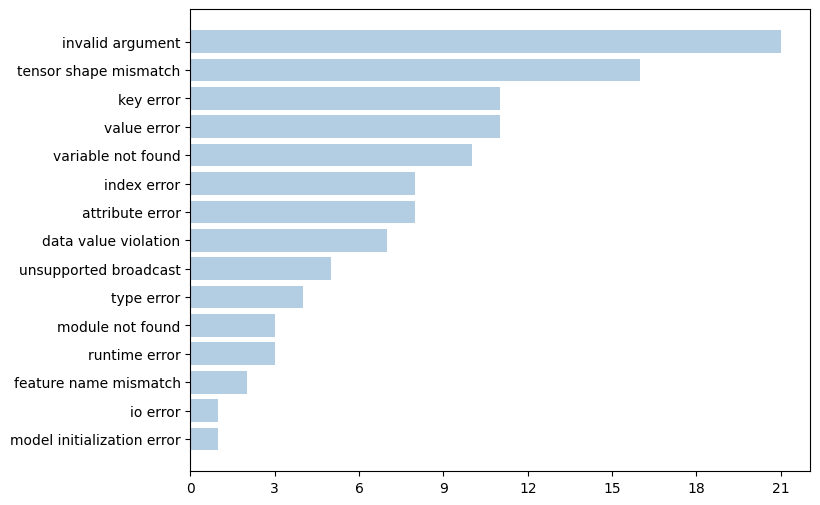

,count
label_refined_exp_type,
invalid argument,21
tensor shape mismatch,16
key error,11
value error,11
variable not found,10
index error,8
attribute error,8
data value violation,7
unsupported broadcast,5


In [11]:
dict_ct = df_bm_labels_all_merged["label_refined_exp_type"].value_counts()

df_ct = pd.DataFrame.from_dict(dict_ct)
df_ct.loc["total"] = df_ct.sum()

# plot
colors = cm['Pastel1'].colors[1]

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(dict_ct.index, dict_ct.values, color=colors)

ax.invert_yaxis()
ax.set_ylabel('')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# plt.savefig(config.path_plot_default.joinpath("crashtype_dist.pdf"), bbox_inches='tight')
plt.show()

df_ct

### Root cause distribution

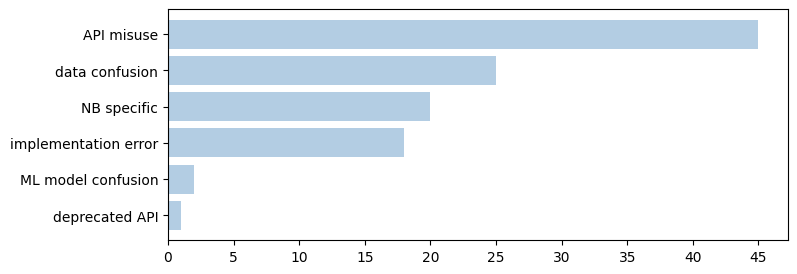

,count
label_root_cause,
API misuse,45
data confusion,25
NB specific,20
implementation error,18
ML model confusion,2
deprecated API,1
total,111


In [12]:
df_bm_labels_all_merged.loc[df_bm_labels_all_merged["label_root_cause"]=="nb specific - need execute future cells","label_root_cause"] = "nb specific - execution order"
df_bm_labels_all_merged.loc[df_bm_labels_all_merged["label_root_cause"]=="library cause","label_root_cause"] = "deprecated API"
dict_rc = df_bm_labels_all_merged["label_root_cause"].value_counts()

df_rc = pd.DataFrame.from_dict(dict_rc)
df_rc.loc["total"] = df_rc.sum()

# plot
colors = cm['Pastel1'].colors[1]

fig, ax = plt.subplots(figsize=(8, 3))
ax.barh(dict_rc.index, dict_rc.values, color=colors)

ax.invert_yaxis()
ax.set_ylabel('')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# plt.savefig(config.path_plot_default.joinpath("rootcause_dist.pdf"), bbox_inches='tight')
plt.show()

df_rc

### Root cause distribution stacked with libraries

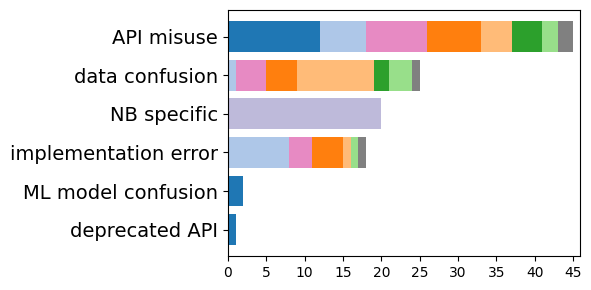

In [14]:
# Count libraries per ML pipeline stage
grouped = df_bm_labels_all_merged.groupby(['label_root_cause', 'Libs-cause']).size().unstack(fill_value=0)

# Libraries to show on the plot
lib_totals = grouped.sum(axis=0)
major_libs = {k: v for k, v in dict_lib.items() if v >= 5}
major_libs['Minor libs'] = sum(v for k, v in dict_lib.items() if v < 5)
reordered_libs = ['TF/K', 'torch', 'sklearn', 'numpy', 'pandas', 
                  'seaborn', 'matplotlib', 'Minor libs', 'NB-specific']
major_libs = {k: major_libs[k] for k in reordered_libs}

# Aggregate minor libraries
grouped['Minor libs'] = grouped[[k for k, v in dict_lib.items() if v<5]].sum(axis=1)
grouped = grouped[list(major_libs.keys())]  # Only keep these columns
grouped = grouped.reindex(dict_rc.index)

# Color setup
major_lib_colors = cm['tab20'].colors[:2] + cm['Set2'].colors[3:4] + cm['tab20'].colors[2:6] + tuple(['gray']) + cm['Set3'].colors[2:3]
lib_color_map = dict(zip(major_libs, major_lib_colors))

# Horizontal stacked bar plot
fig, ax = plt.subplots(figsize=(6, 3))

bottom = pd.Series([0] * len(grouped), index=grouped.index)

for lib in major_libs:
    values = grouped[lib]
    ax.barh(grouped.index, values, left=bottom, color=lib_color_map.get(lib, 'gray')) #, label=lib
    bottom += values

max_total = bottom.max()
ax.set_xlim(right=max_total * 1.02)  # Add padding on the right
ax.tick_params(axis='y', labelsize=14)

# Styling
ax.invert_yaxis()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# ax.legend(title='Library', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save
# plt.savefig(config.path_plot_default.joinpath("rc_stacked_libs.pdf"), bbox_inches='tight')
plt.show()

### ML pipeline stage distribution

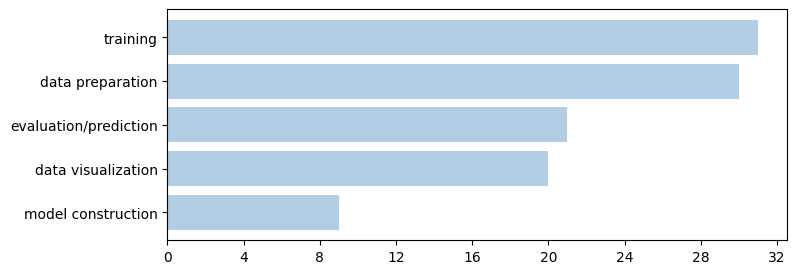

,count
label_ML_pipeline,
training,31
data preparation,30
evaluation/prediction,21
data visualization,20
model construction,9
total,111


In [15]:
dict_mlpp = df_bm_labels_all_merged["label_ML_pipeline"].value_counts()

df_mlpp = pd.DataFrame.from_dict(dict_mlpp)
df_mlpp.loc["total"] = df_mlpp.sum()

# plot
colors = cm['Pastel1'].colors[1]

fig, ax = plt.subplots(figsize=(8, 3))
ax.barh(dict_mlpp.index, dict_mlpp.values, color=colors)

ax.invert_yaxis()
ax.set_ylabel('')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# plt.savefig(config.path_plot_default.joinpath("mlpp_dist.pdf"), bbox_inches='tight')
plt.show()

df_mlpp

### ML pipeline stage distribution stacked with libraries

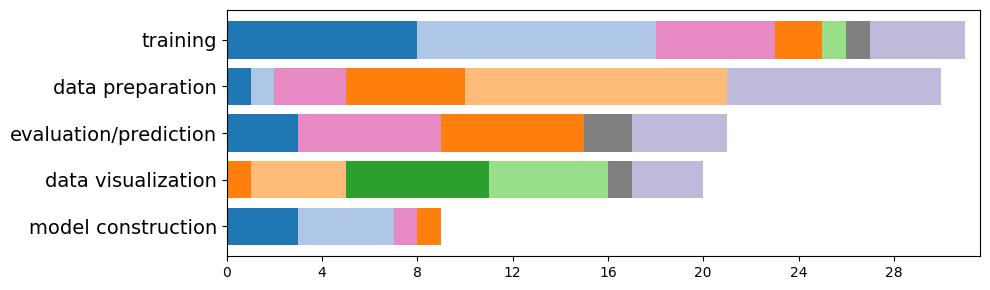

In [16]:
# Count libraries per ML pipeline stage
grouped = df_bm_labels_all_merged.groupby(['label_ML_pipeline', 'Libs-cause']).size().unstack(fill_value=0)

# Libraries to show on the plot
lib_totals = grouped.sum(axis=0)
major_libs = {k: v for k, v in dict_lib.items() if v >= 5}
major_libs['Minor libs'] = sum(v for k, v in dict_lib.items() if v < 5)
reordered_libs = ['TF/K', 'torch', 'sklearn', 'numpy', 'pandas', 
                  'seaborn', 'matplotlib', 'Minor libs', 'NB-specific']
major_libs = {k: major_libs[k] for k in reordered_libs}

# Aggregate minor libraries
grouped['Minor libs'] = grouped[[k for k, v in dict_lib.items() if v<5]].sum(axis=1)
grouped = grouped[list(major_libs.keys())]  # Only keep these columns
grouped = grouped.reindex(dict_mlpp.index)

# Color setup
major_lib_colors = cm['tab20'].colors[:2] + cm['Set2'].colors[3:4] + cm['tab20'].colors[2:6] + tuple(['gray']) + cm['Set3'].colors[2:3]
lib_color_map = dict(zip(major_libs, major_lib_colors))

# Horizontal stacked bar plot
fig, ax = plt.subplots(figsize=(8, 3))

bottom = pd.Series([0] * len(grouped), index=grouped.index)

for lib in major_libs:
    values = grouped[lib]
    ax.barh(grouped.index, values, left=bottom, color=lib_color_map.get(lib, 'gray')) #, label=lib
    bottom += values

max_total = bottom.max()
ax.set_xlim(right=max_total * 1.02)  # Add padding on the right
ax.tick_params(axis='y', labelsize=14)

# Styling
ax.invert_yaxis()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# ax.legend(title='Library', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save
# plt.savefig(config.path_plot_default.joinpath("mlpp_stacked_libs.pdf"), bbox_inches='tight')
plt.show()